In [596]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#grunddaten
inhouse_pv = 0.35 #leistung der PV Anlage in MW
stromkosten = 150 # €/MWh

In [615]:
# ===========
# Zeitprofile
# ===========

# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
renewable_profile_solar = pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float)  # Stündliches, normiertes PV-Erzeugungsprofil
# Building load als csv datei einlesen (kW → MW)
electric_load_profile = pd.read_csv("building_load_G4.csv", usecols=["Last [kW]"])["Last [kW]"].astype(float) / 1000  # In MW

# Building thermal load als csv datei einlesen (kW → MW)
thermal_load_bww = pd.read_csv("bww_load.csv", header=None)[1].astype(float) / 1000  # In MW
thermal_load_heating = pd.read_csv("building_heat_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Temperatur profile
temperature_profile = pd.read_csv("temprature_profile.csv", header=None)[2].astype(float)

# Fleet load profile (kW → MW)
fleet_load_profile = pd.read_csv("fleet_load.csv", header=None)[1].astype(float) / 1000  # In MW

In [ ]:
# ===============================
#netzwerk erstellen with_batterie
# ===============================
with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))

In [599]:
#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")


In [600]:
#hinzufügen generatoren
inhouse_pv = 0.35 #leistung der PV Anlage in MW
with_battery.add("Generator", name="PV", bus="electricity bus", p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=1, overwrite=True )  # PV Betriebskosten: 1 €/MWh
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=200, overwrite=True )  # Netzbezugskosten: 200 €/MWh

In [601]:
#hinzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=electric_load_profile)
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=fleet_load_profile)
with_battery.add("Load", name="DHW_Load",bus="h_bus", p_set=thermal_load_bww)
with_battery.add("Load", name="heating_Load",bus="h_bus2", p_set=thermal_load_heating)


In [602]:
#wärmepumpen

# Umgebungstemperatur in °C
temp        = [-20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] 
# Elektrische Leistungsaufnahme in kW 
el_power    = [10.2, 10.4, 10.6, 10.8, 11.2, 11.5, 11.7, 12.0, 12.2, 12.5] 
# Leistungszahl (COP) der Wärmepumpe bei 35°C Vorlauftemperatur
cop         = [1.65, 1.90, 2.20, 2.50, 3.40, 4.60, 5.10, 6.20, 7.10, 7.50]
# Nominale thermische Leistung (P_th) bei A7/W35 (Referenzpunkt)
hp_p_nom    = 39.5 # kW (thermisch)

# Interpolation für jede Stunde des Jahres
cop_profile = np.interp(temperature_profile, temp, cop)
el_p_pu_profile = np.interp(temperature_profile, temp, el_power) / hp_p_nom

# Wärmepumpe 1: Raumheizung (h_bus2)
with_battery.add("Link", name="h_pump", 
                 bus0="electricity bus", 
                 bus1="h_bus2", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom_extendable=True)

# Wärmepumpe 2: Warmwasser (h_bus)
with_battery.add("Link", name="h_pump2", 
                 bus0="electricity bus", 
                 bus1="h_bus", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom_extendable=True)



In [603]:
#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=300000)  
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=300000)


In [604]:
#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=400000)

In [605]:
without_battery = with_battery.copy()
without_battery.remove("Store", "Battery")


In [606]:
with_battery.optimize(solver_name='highs')
without_battery.optimize(solver_name='highs')

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 325.11it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-glvo3mmn has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [1e+00, 4e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 8e-01]
Presolving model
61320 rows, 65433 cols, 170550 nonzeros  0s
50275 rows, 54388 cols, 151881 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
49699 rows, 53812 cols, 154394 nonzeros  0s
Presolve reductions: rows 49699(-125507); columns 53812(-33794); nonzeros 154394(-178492) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -5.6813243693e-03 Pr: 22849(7903.85) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 7.16e+05
Solver model: available
Solver message: Optimal



      44718     7.1594447603e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-glvo3mmn
Model status        : Optimal
Simplex   iterations: 44718
Objective value     :  7.1594447597e+05
P-D objective error :  1.1219657202e-14
HiGHS run time      :          0.92


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 403.58it/s]
INFO:linopy.io: Writing time: 0.24s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-flleu6lm has 148925 rows; 70085 cols; 271565 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [1e+00, 3e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 8e-01]
Presolving model
43800 rows, 47912 cols, 117990 nonzeros  0s
34219 rows, 35302 cols, 90132 nonzeros  0s
Dependent equations search running on 15583 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
32096 rows, 33123 cols, 87312 nonzeros  0s
Presolve reductions: rows 32096(-116829); columns 33123(-36962); nonzeros 87312(-184253) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     6.8935027709e+05 Pr: 15170(1013.32) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70085 primals, 148925 duals
Objective: 7.16e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      28025     7.1594447603e+05 Pr: 0(0) 1s
      28025     7.1594447603e+05 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-flleu6lm
Model status        : Optimal
Simplex   iterations: 28025
Objective value     :  7.1594447597e+05
P-D objective error :  1.1219657202e-14
HiGHS run time      :          0.61


('ok', 'optimal')

In [618]:
# Energiebilanz der Wärmepumpen

# Stromverbrauch der Wärmepumpen (elektrische Energie rein)
h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # MWh (Strom)
h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # MWh (Strom)
total_hp_electricity = h_pump_electricity + h_pump2_electricity

# Wärmeerzeugung der Wärmepumpen (thermische Energie raus)
h_pump_heat = with_battery.links_t.p1["h_pump"].sum()  # MWh (Wärme)
h_pump2_heat = with_battery.links_t.p1["h_pump2"].sum()  # MWh (Wärme)
total_hp_heat = h_pump_heat + h_pump2_heat

# Durchschnittlicher COP
avg_cop = total_hp_heat / total_hp_electricity if total_hp_electricity > 0 else 0

# Energieeinsparung: Wie viel Strom hätte man OHNE Wärmepumpe gebraucht?
# (Wenn man die Wärme direkt elektrisch erzeugen würde mit COP = 1)
electricity_without_hp = total_hp_heat  # MWh (bei direkter elektrischer Heizung)
electricity_saved = electricity_without_hp - total_hp_electricity

# Prozentuale Einsparung
savings_percentage = (electricity_saved / electricity_without_hp) * 100 if electricity_without_hp > 0 else 0

print("=" * 60)
print("WÄRMEPUMPEN ENERGIEBILANZ")
print("=" * 60)
print(f"Stromverbrauch Wärmepumpe 1 (Heizung): {h_pump_electricity:.1f} MWh")
print(f"Stromverbrauch Wärmepumpe 2 (Warmwasser): {h_pump2_electricity:.1f} MWh")
print(f"Gesamter Stromverbrauch Wärmepumpen: {total_hp_electricity:.1f} MWh")
print("-" * 60)
print(f"Wärmeerzeugung Wärmepumpe 1: {h_pump_heat:.1f} MWh")
print(f"Wärmeerzeugung Wärmepumpe 2: {h_pump2_heat:.1f} MWh")
print(f"Gesamte Wärmeerzeugung: {total_hp_heat:.1f} MWh")
print("-" * 60)
print(f"Durchschnittlicher COP: {avg_cop:.2f}")
print("=" * 60)
print(f"Energieeinsparung gegenüber elektrischer Direktheizung:")
print(f"  {electricity_saved:.1f} MWh ({savings_percentage:.1f}%)")
print("=" * 60)
print(f"\nInterpretation:")
print(f"Für {total_hp_heat:.1f} MWh Wärme wurden nur {total_hp_electricity:.1f} MWh Strom benötigt.")
print(f"Das entspricht einem Wirkungsgrad von {avg_cop:.2f} (COP).")
print(f"Kostenmäßig bedeutet dies eine Einsparung von {electricity_saved * -200:.2f} € (bei 200 €/MWh Stromkosten).")

WÄRMEPUMPEN ENERGIEBILANZ
Stromverbrauch Wärmepumpe 1 (Heizung): 127.1 MWh
Stromverbrauch Wärmepumpe 2 (Warmwasser): 10.1 MWh
Gesamter Stromverbrauch Wärmepumpen: 137.1 MWh
------------------------------------------------------------
Wärmeerzeugung Wärmepumpe 1: -495.5 MWh
Wärmeerzeugung Wärmepumpe 2: -46.4 MWh
Gesamte Wärmeerzeugung: -541.9 MWh
------------------------------------------------------------
Durchschnittlicher COP: -3.95
Energieeinsparung gegenüber elektrischer Direktheizung:
  -679.0 MWh (0.0%)

Interpretation:
Für -541.9 MWh Wärme wurden nur 137.1 MWh Strom benötigt.
Das entspricht einem Wirkungsgrad von -3.95 (COP).
Kostenmäßig bedeutet dies eine Einsparung von 135806.80 € (bei 200 €/MWh Stromkosten).


In [607]:
# Investitionskosten berechnen

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

# Wärmepumpen-Investitionskosten (falls Sie capital_cost hinzufügen)
h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]  # MW
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"]  # MW
# Beispiel: 500.000 €/MW für Wärmepumpen (Sie müssen den realen Wert einsetzen)
h_pump_cost = 500000  # €/MW
h_pump_investment = (h_pump_capacity + h_pump2_capacity) * h_pump_cost

# Gesamte Investitionskosten
total_investment = (battery_investment + thermal_storage_investment + 
                   dhw_storage_investment + h_pump_investment)

print("=" * 50)
print("INVESTITIONSKOSTEN")
print("=" * 50)
print(f"Batteriespeicher: {battery_investment:,.2f} €")
print(f"Wärmespeicher (Heizung): {thermal_storage_investment:,.2f} €")
print(f"Warmwasserspeicher: {dhw_storage_investment:,.2f} €")
print(f"Wärmepumpen: {h_pump_investment:,.2f} €")
print("=" * 50)
print(f"GESAMT: {total_investment:,.2f} €")
print("=" * 50)

INVESTITIONSKOSTEN
Batteriespeicher: -0.00 €
Wärmespeicher (Heizung): -0.00 €
Warmwasserspeicher: -0.00 €
Wärmepumpen: 32,830.23 €
GESAMT: 32,830.23 €


In [608]:
print("batterie größe: ", with_battery.stores.at["Battery", "e_nom_opt"])
print("thermalstorage größe: ", with_battery.stores.at["Thermal_Storage", "e_nom_opt"])
print("DHW storage größe: ", with_battery.stores.at["DHW_Storage", "e_nom_opt"])

batterie größe:  -0.0
thermalstorage größe:  -0.0
DHW storage größe:  -0.0


In [609]:
print(f"Grid Leistung: {with_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {with_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")
pv_energy = with_battery.generators_t.p["PV"].sum()  
print(f"PV Energieerzeugung über das Jahr: {pv_energy:.2f} MWh")    

print(f"Grid Leistung: {without_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {without_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")

Grid Leistung: 0.84 MW
PV Leistung: 0.35 MW
PV Energieerzeugung über das Jahr: 375.75 MWh
Grid Leistung: 0.84 MW
PV Leistung: 0.35 MW


In [610]:
grid_energy_ohne = without_battery.generators_t.p["Grid"].sum()
grid_energy_mit = with_battery.generators_t.p["Grid"].sum()

print(f"Netzbezug ohne Batterie: {grid_energy_ohne:.1f} MWh")
print(f"Netzbezug mit Batterie: {grid_energy_mit:.1f} MWh")
print(f"Einsparung: {grid_energy_ohne - grid_energy_mit:.1f} MWh")

Netzbezug ohne Batterie: 3577.8 MWh
Netzbezug mit Batterie: 3577.8 MWh
Einsparung: 0.0 MWh


In [621]:
# Elektrische Lasten
building_load = with_battery.loads_t.p["building_load"].sum()
fleet_load = with_battery.loads_t.p["fleet_load"].sum()

# Wärmepumpen-Stromverbrauch
h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # Strom rein
h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # Strom rein

# GESAMTER Stromverbrauch (direkt + Wärmepumpen)
total_electricity_demand = building_load + fleet_load + h_pump_electricity + h_pump2_electricity

# Autarkiegrad
pv_energy = with_battery.generators_t.p["PV"].sum()
autarky = (pv_energy / total_electricity_demand) * 100

print(f"PV-Erzeugung: {pv_energy:.1f} MWh")
print(f"Stromverbrauch (direkt): {building_load + fleet_load:.1f} MWh")
print(f"Stromverbrauch (Wärmepumpen): {h_pump_electricity + h_pump2_electricity:.1f} MWh")
print(f"Gesamter Stromverbrauch: {total_electricity_demand:.1f} MWh")
print(f"Autarkiegrad: {autarky:.1f}%")
print(f"Kosten für PV-Anlage: {inhouse_pv * 700000:.2f} €")
print(f"kosteneinsparung durch PV: {(pv_energy * 200):.2f} € (bei 200 €/MWh Stromkosten)")
print("amortisationszeit der PV Anlage: {:.1f} Jahre".format((inhouse_pv * 700000) / (pv_energy * 200)))


PV-Erzeugung: 375.7 MWh
Stromverbrauch (direkt): 3816.5 MWh
Stromverbrauch (Wärmepumpen): 137.1 MWh
Gesamter Stromverbrauch: 3953.6 MWh
Autarkiegrad: 9.5%
Kosten für PV-Anlage: 245000.00 €
kosteneinsparung durch PV: 75149.70 € (bei 200 €/MWh Stromkosten)
amortisationszeit der PV Anlage: 3.3 Jahre


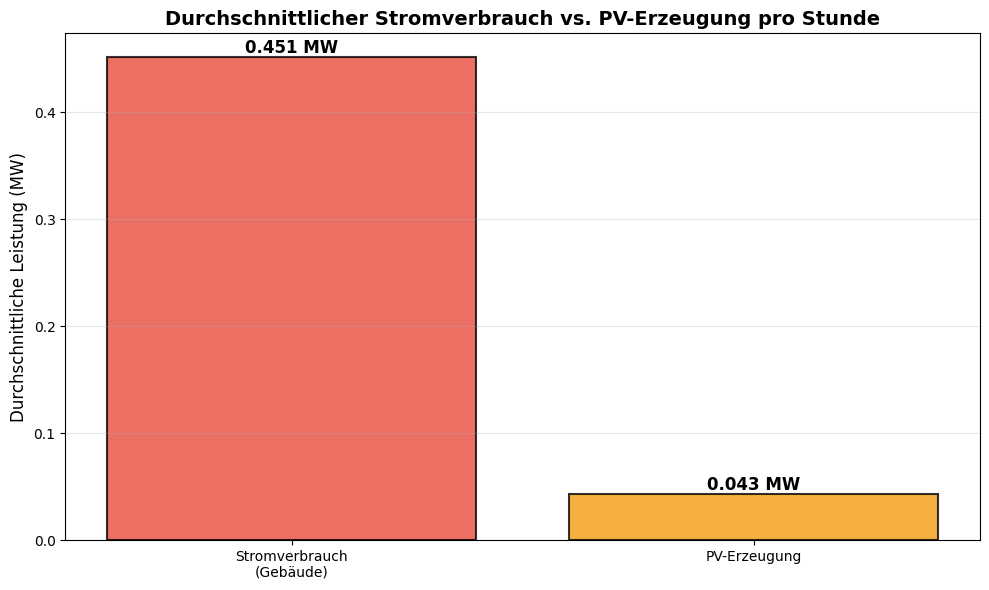

In [612]:
# Balkendiagramm: Durchschnittlicher Stromverbrauch vs. PV-Erzeugung
avg_building_load = total_electricity_demand / 8760
avg_pv_generation = pv_energy / 8760

plt.figure(figsize=(10, 6))
categories = ['Stromverbrauch\n(Gebäude)', 'PV-Erzeugung']
values = [avg_building_load, avg_pv_generation]
colors = ['#E74C3C', '#F39C12']

bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Werte auf den Balken anzeigen
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f} MW',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Durchschnittliche Leistung (MW)', fontsize=12)
plt.title('Durchschnittlicher Stromverbrauch vs. PV-Erzeugung pro Stunde', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

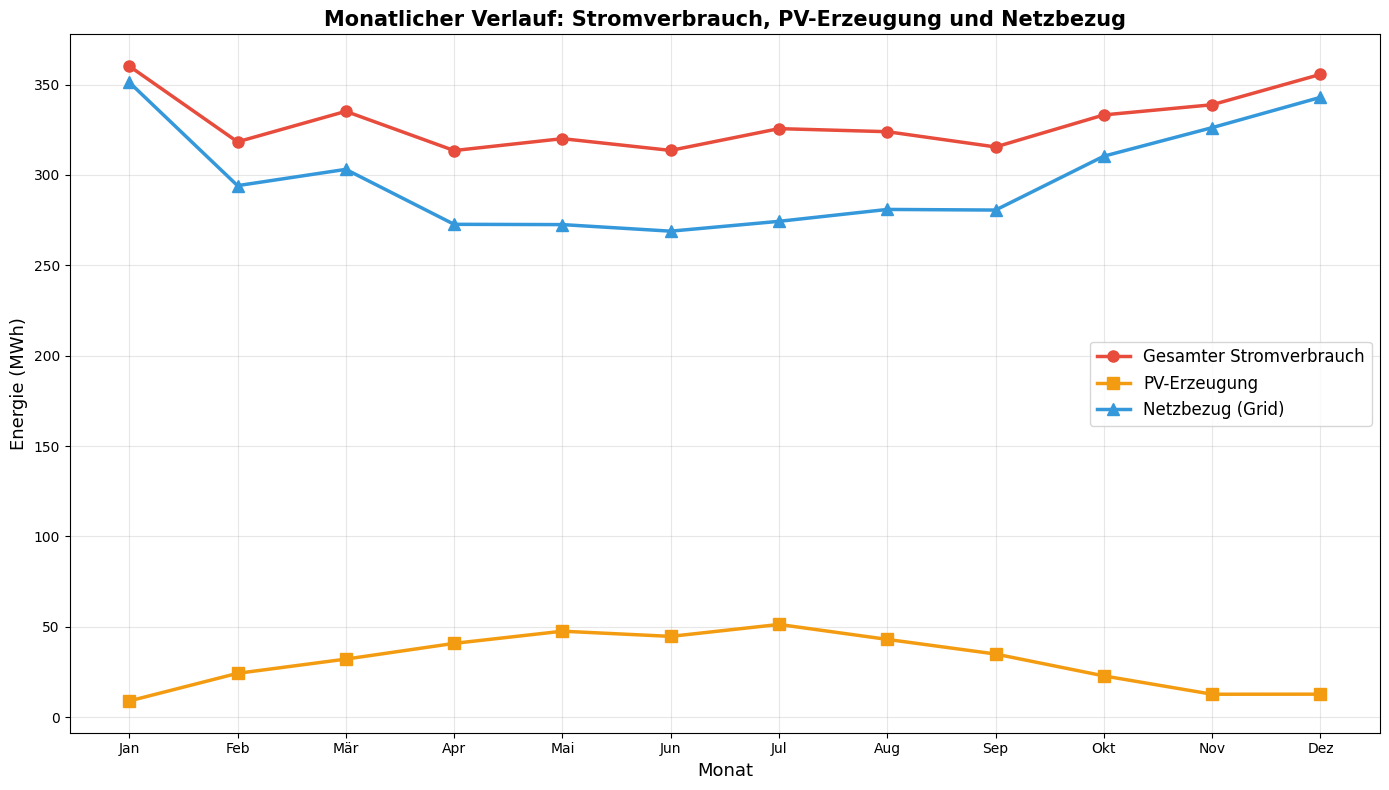

In [613]:
# Plot: Monatlicher Verlauf von Stromverbrauch, Grid-Bezug und PV-Erzeugung
plt.figure(figsize=(14, 8))

# Gesamter Stromverbrauch (direkt + Wärmepumpen)
total_load = (with_battery.loads_t.p["building_load"] + 
              with_battery.loads_t.p["fleet_load"] + 
              with_battery.links_t.p0["h_pump"] + 
              with_battery.links_t.p0["h_pump2"]).values

# PV-Erzeugung
pv_generation = with_battery.generators_t.p["PV"].values

# Grid-Bezug
grid_power = with_battery.generators_t.p["Grid"].values

# Umwandlung in monatliche Summen (MWh)
hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # Stunden pro Monat
months = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']

monthly_load = []
monthly_pv = []
monthly_grid = []

start_hour = 0
for hours in hours_per_month:
    end_hour = start_hour + hours
    monthly_load.append(total_load[start_hour:end_hour].sum())
    monthly_pv.append(pv_generation[start_hour:end_hour].sum())
    monthly_grid.append(grid_power[start_hour:end_hour].sum())
    start_hour = end_hour

# Plots
plt.plot(months, monthly_load, label='Gesamter Stromverbrauch', linewidth=2.5, color='#E74C3C', marker='o', markersize=8)
plt.plot(months, monthly_pv, label='PV-Erzeugung', linewidth=2.5, color='#F39C12', marker='s', markersize=8)
plt.plot(months, monthly_grid, label='Netzbezug (Grid)', linewidth=2.5, color='#3498DB', marker='^', markersize=8)

plt.xlabel('Monat', fontsize=13)
plt.ylabel('Energie (MWh)', fontsize=13)
plt.title('Monatlicher Verlauf: Stromverbrauch, PV-Erzeugung und Netzbezug', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()